In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
sys.path.append('/home/ubuntu/fastai/')

In [4]:
from fastai.imports import *

In [5]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import*
from fastai.sgdr import *
from fastai.plots import *

In [14]:
PATH = '/home/ubuntu/data/dogscats/'
sz=224

In [15]:
torch.cuda.is_available()

True

In [16]:
torch.backends.cudnn.enabled

True

In [17]:
os.listdir(PATH)

['test1', 'valid', 'train', 'sample']

In [18]:
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [21]:
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.1935.jpg',
 'cat.12009.jpg',
 'cat.6320.jpg',
 'cat.2203.jpg',
 'cat.3808.jpg']

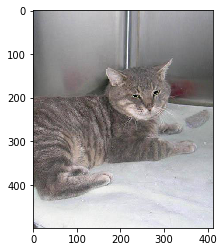

In [22]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

In [23]:
img.shape

(499, 412, 3)

In [24]:
img[:4, :4]

array([[[102, 110, 113],
        [107, 114, 120],
        [111, 118, 124],
        [110, 117, 125]],

       [[102, 110, 113],
        [107, 114, 120],
        [111, 118, 124],
        [110, 117, 125]],

       [[103, 111, 114],
        [106, 113, 119],
        [110, 117, 123],
        [109, 116, 124]],

       [[103, 111, 114],
        [106, 113, 119],
        [108, 115, 121],
        [108, 115, 123]]], dtype=uint8)

In [26]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

100%|██████████| 32/32 [00:10<00:00,  2.97it/s]


epoch      trn_loss   val_loss   accuracy                     
    0      0.04425    0.02573    0.989     
    1      0.040775   0.023349   0.992                        



[0.023349322572350503, 0.992]

In [27]:
data.classes

['cats', 'dogs']

In [28]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [29]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [30]:
log_preds[:10]

array([[ -0.00003, -10.57397],
       [ -0.00392,  -5.54386],
       [ -0.00002, -10.75756],
       [ -0.00075,  -7.20201],
       [ -0.00001, -11.12875],
       [ -0.00005,  -9.81989],
       [ -0.00001, -11.77621],
       [ -0.00016,  -8.74235],
       [ -0.00021,  -8.46564],
       [ -0.00001, -11.4294 ]], dtype=float32)

In [31]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:, 1])

In [32]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y) == is_correct)

In [36]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [37]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds, x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

CORRECTLY CLASSIFIED


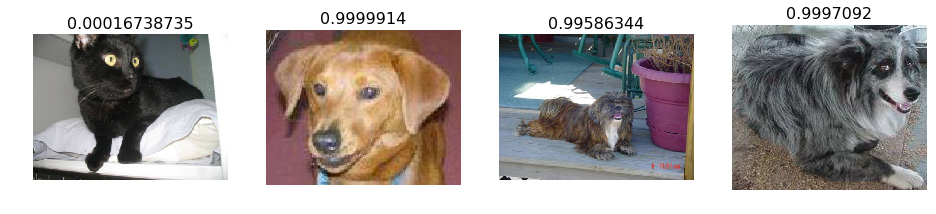

In [38]:
plot_val_with_title(rand_by_correct(True), "CORRECTLY CLASSIFIED" )

INCORRECTLY CLASSIFIED


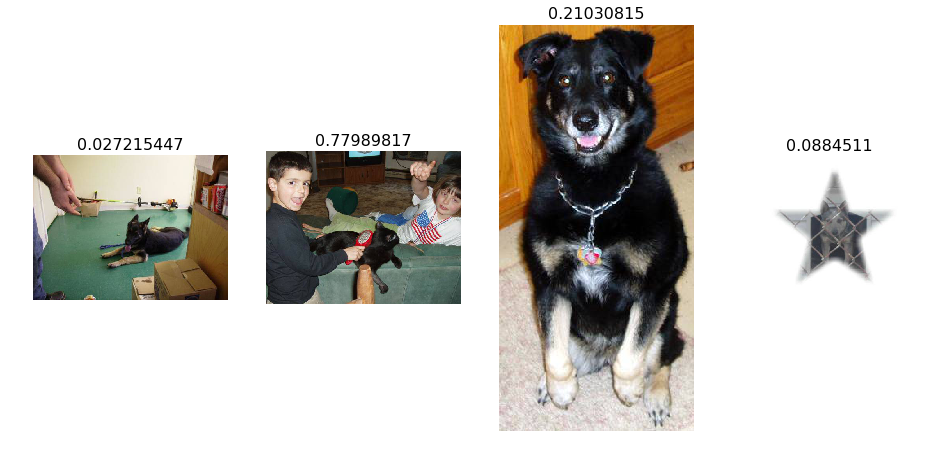

In [40]:
plot_val_with_title(rand_by_correct(False), "INCORRECTLY CLASSIFIED")

In [41]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

In [42]:
def most_by_correct(y, is_correct):
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y) == is_correct & (data.val_y == y), mult)

Most Correct Cats


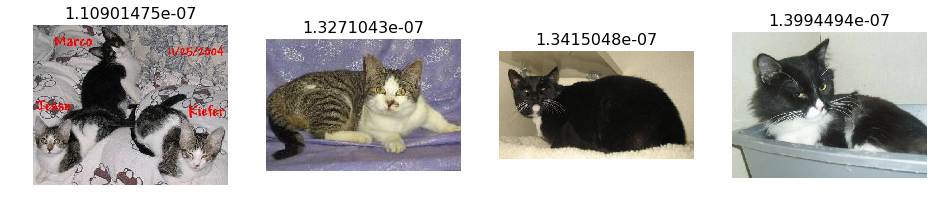

In [43]:
plot_val_with_title(most_by_correct(0, True), "Most Correct Cats")

Most Correct Dogs


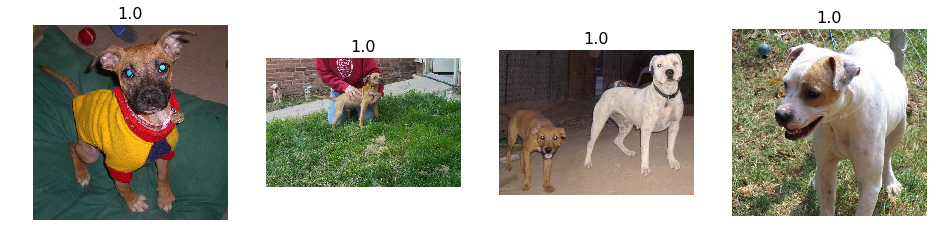

In [44]:
plot_val_with_title(most_by_correct(1, True), "Most Correct Dogs")

Most Incorrect Dogs


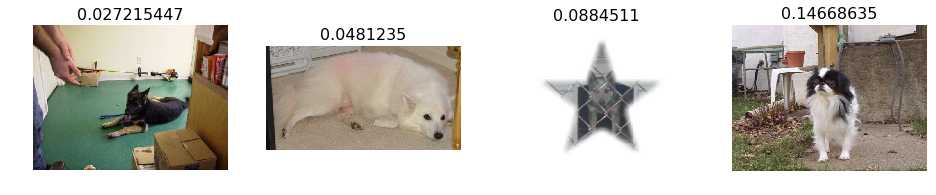

In [45]:
plot_val_with_title(most_by_correct(1, False), "Most Incorrect Dogs")

Most Uncertain Predictions


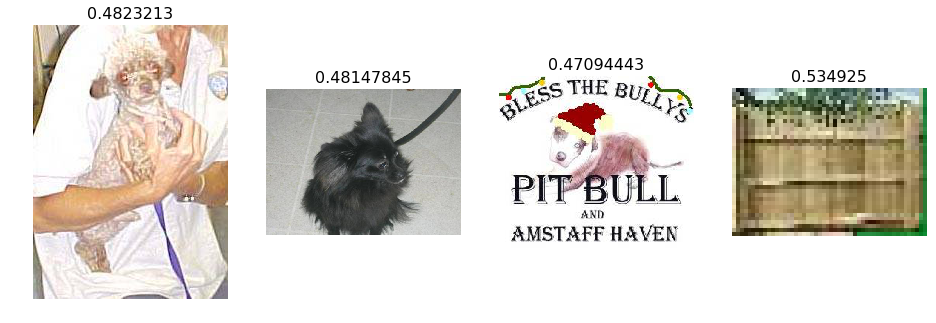

In [46]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most Uncertain Predictions")

In [47]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [48]:
lrf = learn.lr_find()

 80%|███████▉  | 287/360 [00:03<00:00, 73.53it/s, loss=0.177]


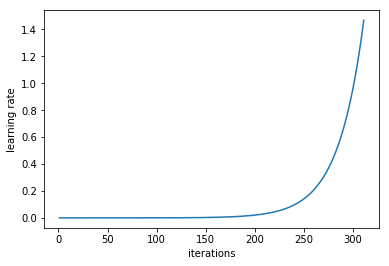

In [50]:
learn.sched.plot_lr()

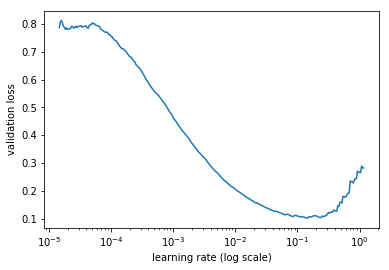

In [51]:
learn.sched.plot()

In [52]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [53]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x, _ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [54]:
ims = np.stack([get_augs() for i in range(6)])

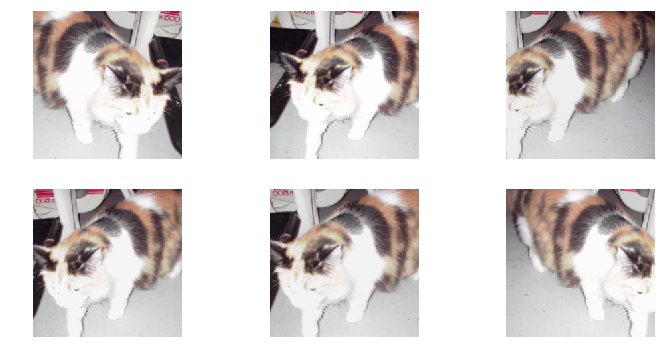

In [55]:
plots(ims, rows=2)

In [56]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [57]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.048895   0.025508   0.9905    



[0.025508424893021582, 0.9905]

In [58]:
learn.precompute=False

In [59]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.043692   0.026275   0.9895    
    1      0.044423   0.028954   0.9895                       
    2      0.037658   0.025823   0.987                        



[0.02582336749136448, 0.987]

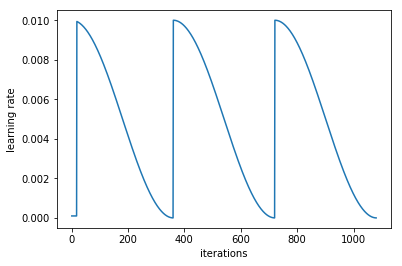

In [60]:
learn.sched.plot_lr()

In [61]:
learn.save('224_lastlayer')
learn.load('224_lastlayer')

In [62]:
learn.unfreeze()

In [63]:
lr=np.array([1e-4, 1e-3, 1e-2])

In [64]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.047291   0.029745   0.989     
    1      0.040799   0.020542   0.9905                       
    2      0.029672   0.019855   0.9915                       
    3      0.029387   0.019973   0.991                        
    4      0.026191   0.016686   0.9925                       
    5      0.025866   0.016738   0.993                        
    6      0.016887   0.018958   0.9915                       



[0.018957764193415643, 0.9915]

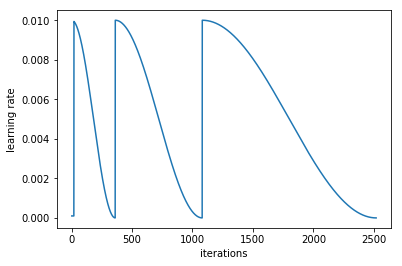

In [65]:
learn.sched.plot_lr()

In [66]:
learn.save('224_all')
learn.load('224_all')

In [68]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)

In [70]:
accuracy_np(probs, y)

0.9945

In [ ]:
preds = np.argmax(probs, axis=1)
probs = probs[:, 1]

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

In [ ]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

In [ ]:
tfms = tfms_from_model(arch, sz)

In [ ]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

In [ ]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True)

In [ ]:
learn.fit(1e-2, 1)

In [81]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y) * np.log(1-p)))

In [82]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

0.164252033486018